In [1]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [2]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [3]:
# PACKAGE LIST: pip list

import scanpy as sc
import scirpy as ir
import pandas as pd
import muon as mu
import csv
import anndata
import matplotlib.pyplot as plt
import celltypist as celltypist
from celltypist import models

import numpy as np
import seaborn as sns 
from scipy.stats import median_abs_deviation
from cycler import cycler

from matplotlib import cm as mpl_cm

In [4]:
# Read previous mdata
mdata=mu.read_h5mu('msc_mdata3.h5mu')
mdata

C:\Users\gaura\miniconda3\Lib\site-packages\anndata\utils.py:334: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


MuData object with n_obs × n_vars = 21699 × 25691
  obs:	'sample', 'group', 'batch'
  uns:	'clonotype_modularity'
  2 modalities
    gex:	20554 x 25691
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'sample', 'group', 'batch', 'liver', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'celltypist_cell_label_fine', 'celltypist_conf_score_fine'
      var:	'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'airr:cc_aa_tcrdist_colors', 'airr:chain_pairing_colors', 'airr:clonal_expansion_colors', 'batch_colors', 'celltypist_cell_label_fine_colors', 'dendrogram_celltypist_cell_label_fine', 'group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_res0_25', 'leiden_res0_25_colors', 'leiden_res0_5', 'leiden_res0_5_colors', 'leiden_res1', 'leiden_res1_colors', 'log1p', 'neighbors', 'pca', 'predicted_doublet_colors', 'rank_genes_groups', 'sample_colors', 'scrublet', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    airr:	6745 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size', 'cc_aa_tcrdist', 'cc_aa_tcrdist_size', 'clonal_expansion', 'clonotype_modularity', 'clonotype_modularity_fdr'
      uns:	'cc_aa_tcrdist', 'chain_indices', 'clone_id', 'clonotype_network', 'ir_dist_aa_tcrdist', 'ir_dist_nt_identity'
      obsm:	'X_clonotype_network', 'airr', 'chain_indices'

In [5]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [16]:
# 4.1 Database queries

In [7]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [8]:
# Load vdj database
vdjdb = ir.datasets.vdjdb()

  0%|          | 0/4656 [00:00<?, ?it/s]

  0%|          | 0/6579 [00:00<?, ?it/s]

In [12]:
# Query vdjdb to the clonotypes vdj sequences
ir.pp.ir_dist(
    mdata,
    vdjdb,
    metric="tcrdist",
    sequence="aa",
    cutoff=15,
)

ir.tl.define_clonotype_clusters(mdata, sequence="aa", metric="tcrdist", receptor_arms="all", dual_ir="any")
ir.tl.clonotype_network(mdata, min_cells=5, sequence="aa", metric="tcrdist")
ir.tl.ir_query(
    mdata,
    vdjdb,
    metric="tcrdist",
    sequence="aa",
    receptor_arms="any",
    dual_ir="any",
)
# Annotate our vdj sequences
ir.tl.ir_query_annotate_df(
    mdata,
    vdjdb,
    metric="tcrdist",
    sequence="aa",
    include_ref_cols=["antigen.species", "antigen.gene", 'antigen.epitope'], 
).tail()
ir.tl.ir_query_annotate(
    mdata,
    vdjdb,
    metric="tcrdist",
    sequence="aa",
    include_ref_cols=["antigen.species", "antigen.gene", 'antigen.epitope'],
    strategy="most-frequent",
)

  0%|          | 0/4656 [00:00<?, ?it/s]

  0%|          | 0/4656 [00:00<?, ?it/s]

  0%|          | 0/19032 [00:00<?, ?it/s]

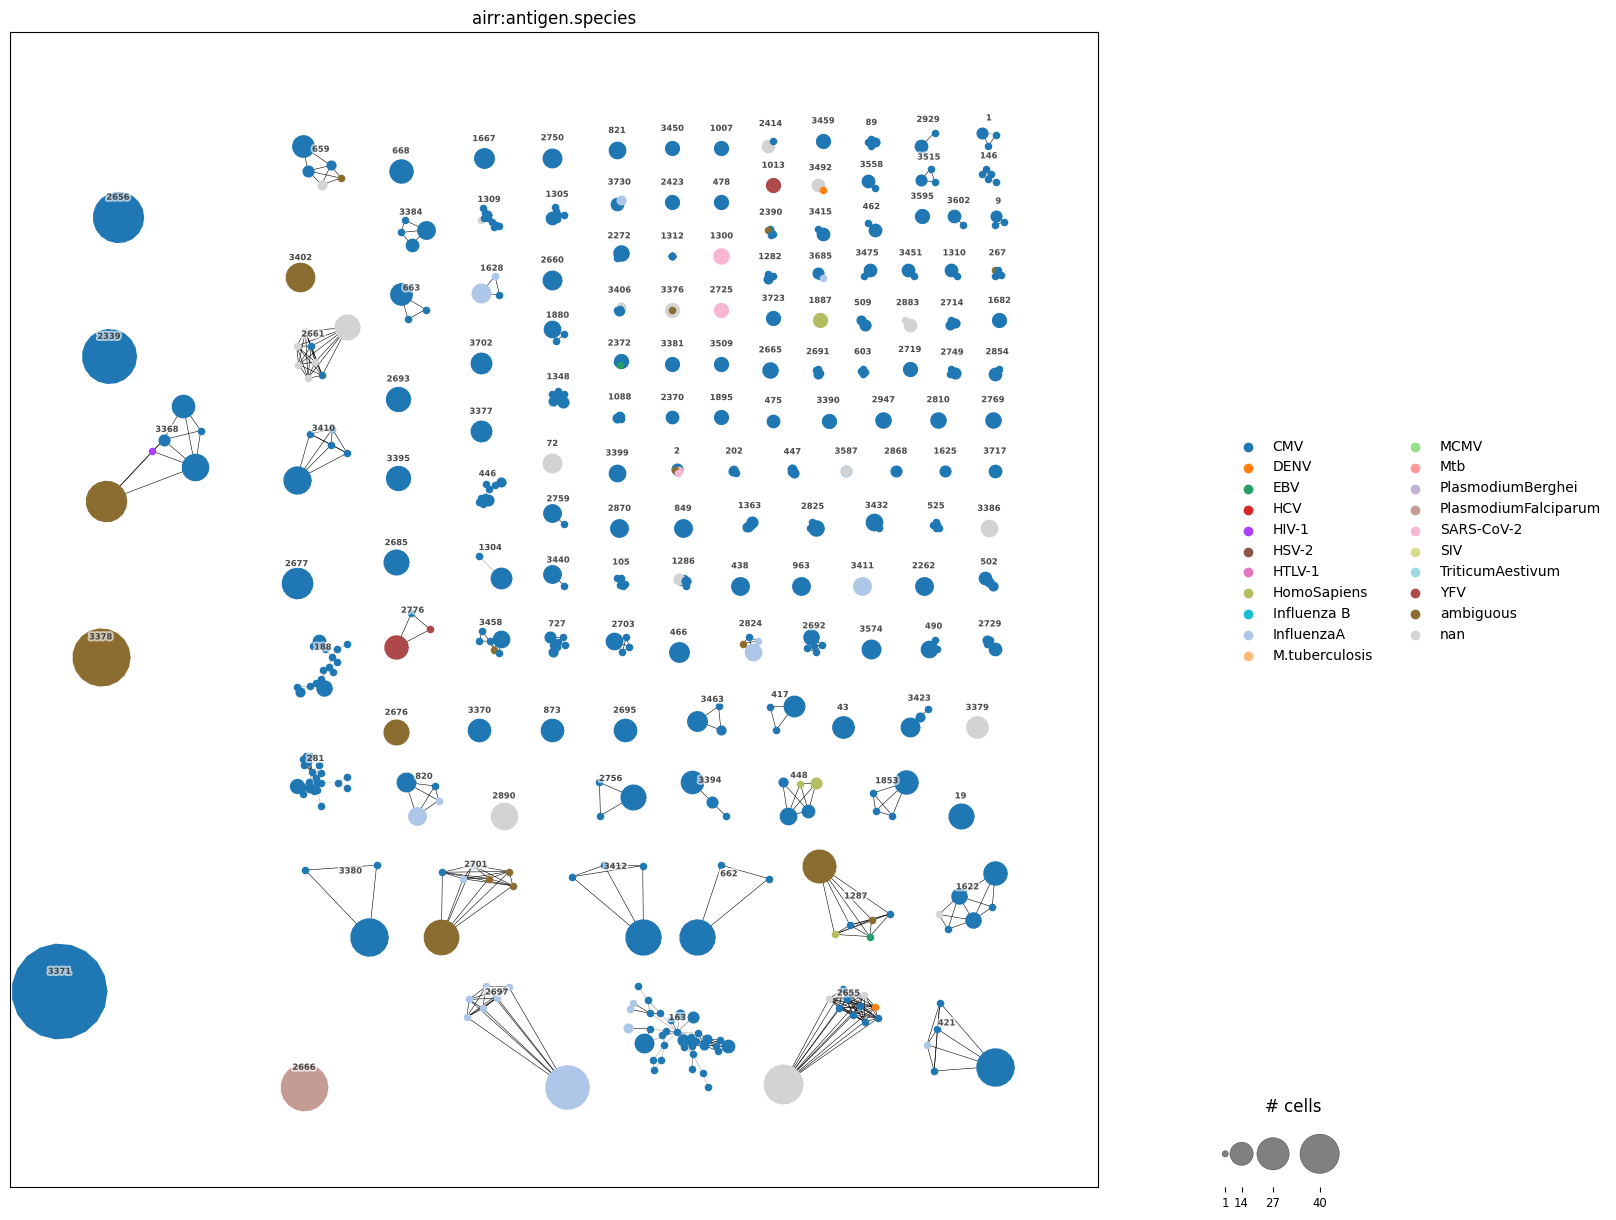

In [14]:
# Plot vdj matches 
_ = ir.pl.clonotype_network(mdata, color="airr:antigen.species", label_fontsize=6, panel_size=(15, 15), base_size=20,    fig_kws={"dpi": 100}) #airr:antigen.species

In [ ]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [ ]:
# 4.2 Epitope binding predictions

In [ ]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [17]:
# Pulling data required for epitope binding predictions
with ir.get.airr_context(mdata, "junction_aa", ["VJ_1", "VDJ_1", "VJ_2", "VDJ_2"]):
    clonotype_info = (
        mdata.obs.loc[lambda x: x["airr:antigen.species"] == "CMV"]
        .astype(str)
        .groupby(
            [
                "VJ_1_junction_aa",
                "VDJ_1_junction_aa",
                #"VJ_2_junction_aa",
                #"VDJ_2_junction_aa",
                "airr:receptor_subtype",
                "airr:antigen.species",
                'airr:antigen.epitope',
                'airr:cc_aa_tcrdist',
                #'airr:cc_aa_tcrdist',
                #'airr:clone_id',
                #'airr:antigen.epitope',
                #'gex:liver',
                #'gex:svp',
                'gex:sample',
                'gex:group',
            ],
            observed=True,
            dropna=False,
        )
        .size()
        .reset_index(name="n_cells")
    )
clonotype_info

... storing 'VJ_1_junction_aa' as categorical
... storing 'VDJ_1_junction_aa' as categorical
... storing 'VJ_2_junction_aa' as categorical
... storing 'VDJ_2_junction_aa' as categorical


,VJ_1_junction_aa,VDJ_1_junction_aa,airr:receptor_subtype,airr:antigen.species,airr:antigen.epitope,airr:cc_aa_tcrdist,gex:sample,gex:group,n_cells
0,CAAAAGFQKLVF,CSAAGDRDGEQYF,TRA+TRB,CMV,KLGGALQAK,2762,nan,nan,1
1,CAAADSNYQLIW,CSARGGAPQETQYF,TRA+TRB,CMV,KLGGALQAK,1710,10113-2-L,F0,1
2,CAAAGTYKYIF,CASSQAPGATGELFF,TRA+TRB,CMV,KLGGALQAK,2471,10205-L,F2,1
3,CAAATEGGTSYGKLTF,CATSDRGQLGARGDTQYF,TRA+TRB,CMV,KLGGALQAK,345,9680-L,F1,1
4,CAAATGTASKLTF,CASSLGPGSNNEQFF,TRA+TRB,CMV,KLGGALQAK,1457,10113-1-L,F1,1
...,...,...,...,...,...,...,...,...,...
3392,CVVTPGVNNDMRF,CASSLWRQETQYF,TRA+TRB,CMV,ambiguous,951,9999-L,F0,2
3393,CVVTSPDGQNFVF,CASSEAGRETQYF,TRA+TRB,CMV,ambiguous,1947,10202-L,F1,1
3394,CVVVHAGGTSYGKLTF,CASSYLQANSPLHF,TRA+TRB,CMV,KLGGALQAK,1954,10202-L,F1,1
3395,CVVYPGGGADGLTF,CASSPGGNNQPQHF,TRA+TRB,CMV,KLGGALQAK,1732,10113-2-L,F0,1


In [82]:
# Creating new data frame for required data
dfnew=clonotype_info[clonotype_info['n_cells']>1]
dfnew=dfnew.sort_values(by='n_cells', ascending=False)
dfnew
#
cmvdf=dfnew[['VJ_1_junction_aa','VDJ_1_junction_aa']]
cmvdf=df.rename(columns={'VJ_1_junction_aa':'TRA', 'VDJ_1_junction_aa':'TRB'})
cmvdf['TRAV']=''
cmvdf['TRAJ']=''
cmvdf['TRBV']=''
cmvdf['TRBJ']=''
cmvdf['T-Cell-Type']=''
cmvdf['Peptide']=dfnew['airr:antigen.epitope']
cmvdf['MHC']=''
cmvdf=cmvdf[cmvdf['Peptide']!='ambiguous']
cmvdf = cmvdf.drop_duplicates()
cmvdf=cmvdf.set_index('TRA')
cmvdf.to_csv('ergo_cmv_seq_input.csv')

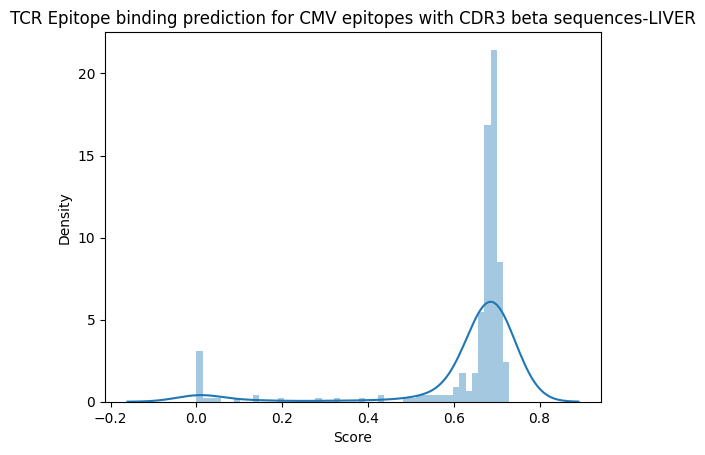

In [85]:
# Epitope prediction results
df_tcr_ergo = pd.read_csv("results.csv")
#df_tcr_ergo.head()
sns.distplot(df_tcr_ergo["Score"])
plt.title('TCR Epitope binding prediction for CMV epitopes with CDR3 beta sequences-LIVER')
plt.show()

In [86]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [ ]:
# 4.3 Further clonotype analysis

In [87]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

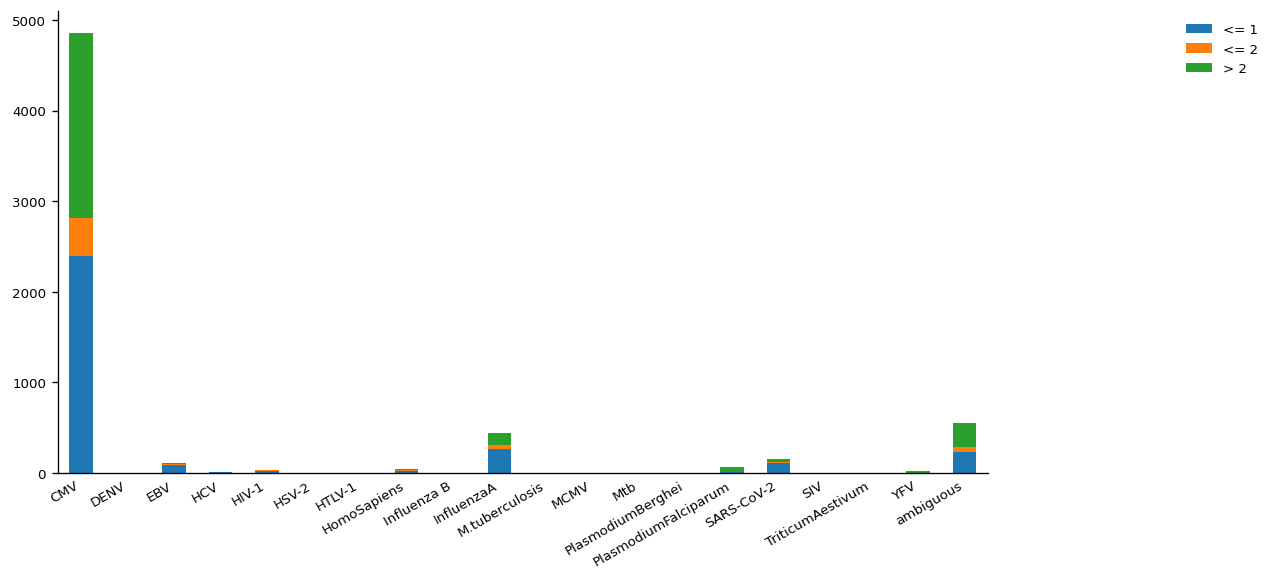

In [94]:
_ = ir.pl.clonal_expansion(mdata, target_col="cc_aa_tcrdist", groupby="airr:antigen.species", breakpoints=(1,2), normalize=False, figsize=(10,5))

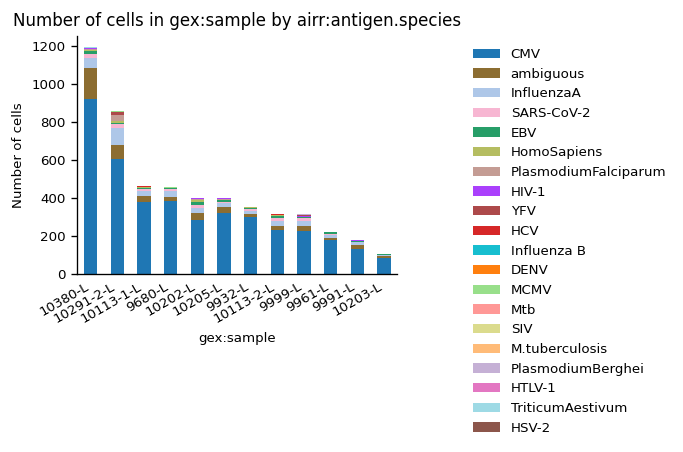

In [95]:
ax = ir.pl.group_abundance(mdata, groupby="gex:sample", target_col="airr:antigen.species")

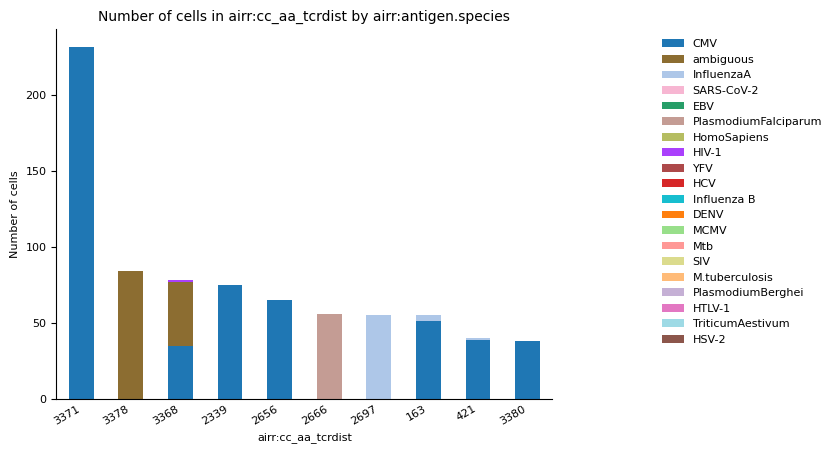

In [96]:
_ = ir.pl.group_abundance(mdata, groupby="airr:cc_aa_tcrdist", target_col="airr:antigen.species", max_cols=10,    fig_kws={"dpi": 100},)

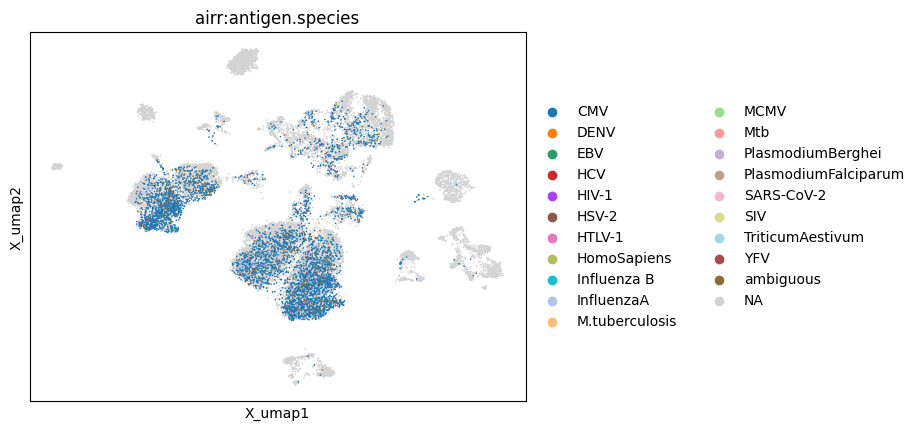

In [97]:
mu.pl.embedding(mdata, "gex:umap", color="airr:antigen.species")

In [88]:
#########################################################################################################################################
#########################################################################################################################################
#########################################################################################################################################

In [ ]:
# Extra data analysis for more results

In [101]:
with ir.get.airr_context(mdata, "junction_aa", ["VJ_1", "VDJ_1", "VJ_2", "VDJ_2"]):
    clonotype_info = (
        mdata.obs.loc[lambda x: x["airr:antigen.species"] == "HCV"] 
        .astype(str)
        .groupby(
            [
                "VJ_1_junction_aa",
                "VDJ_1_junction_aa",
                "VJ_2_junction_aa",
                "VDJ_2_junction_aa",
                "airr:receptor_subtype",
                #"airr:Epitope Source Organism",
                "airr:antigen.species",
                #'airr:antigen.epitope',
                #'airr:cc_aa_tcrdist',
                #'airr:clone_id',
                #'airr:antigen.epitope',
               # 'gex:liver',
               # 'gex:svp',
                'gex:sample',
            ],
            observed=True,
            dropna=False,
        )
        .size()
        .reset_index(name="n_cells")
    )

clonotype_info

... storing 'VJ_1_junction_aa' as categorical
... storing 'VDJ_1_junction_aa' as categorical
... storing 'VJ_2_junction_aa' as categorical
... storing 'VDJ_2_junction_aa' as categorical


,VJ_1_junction_aa,VDJ_1_junction_aa,VJ_2_junction_aa,VDJ_2_junction_aa,airr:receptor_subtype,airr:antigen.species,gex:sample,n_cells
0,CAESQAGDGQKLLF,CASSITGAEQYF,nan,nan,TRA+TRB,HCV,10202-L,1
1,CAFLALNSGYALNF,CASSPYGFPPTDTQYF,nan,nan,TRA+TRB,HCV,nan,1
2,CAGAQGSNYQLIW,CASSPSSGSKNIQYF,nan,nan,TRA+TRB,HCV,9991-L,1
3,CAGRPPSGSRLTF,CASSPWGISGSYEQYF,nan,nan,TRA+TRB,HCV,10203-L,3
4,CALSDRFSDGQKLLF,CASLPSGGYTDTQYF,CAVRPSGSQGNLIF,nan,TRA+TRB,HCV,nan,1
5,CAVIGSTLTF,CSAYGQGANYGYTF,nan,nan,TRA+TRB,HCV,nan,1
6,CAVKGFRGDNFNKFYF,CSVRVLGNEQFF,nan,CASSEAIASYNEQFF,TRA+TRB,HCV,10113-2-L,1
7,CAVTAGDYKLSF,CASSFEETQYF,nan,nan,TRA+TRB,HCV,9999-L,1
8,CAVTDGDYKLSF,CASSISQGSGANVLTF,nan,nan,TRA+TRB,HCV,10113-1-L,1
9,CAVTDGDYKLSF,CASSQDGASGGNEQFF,nan,nan,TRA+TRB,HCV,10205-L,1


In [103]:
with ir.get.airr_context(mdata, "junction_aa", ["VJ_1", "VDJ_1", "VJ_2", "VDJ_2"]):
    clonotype_info = (
        mdata.obs.loc[lambda x: x["airr:antigen.species"] == "ambiguous"] 
        .astype(str)
        .groupby(
            [
                "VJ_1_junction_aa",
                "VDJ_1_junction_aa",
                "VJ_2_junction_aa",
                "VDJ_2_junction_aa",
                "airr:receptor_subtype",
                #"airr:Epitope Source Organism",
                "airr:antigen.species",
                #'airr:antigen.epitope',
                #'airr:cc_aa_tcrdist',
                #'airr:clone_id',
                #'airr:antigen.epitope',
               # 'gex:liver',
               # 'gex:svp',
                'gex:sample',
            ],
            observed=True,
            dropna=False,
        )
        .size()
        .reset_index(name="n_cells")
    )
clonotype_info=clonotype_info[clonotype_info['n_cells']>1]
clonotype_info

... storing 'VJ_1_junction_aa' as categorical
... storing 'VDJ_1_junction_aa' as categorical
... storing 'VJ_2_junction_aa' as categorical
... storing 'VDJ_2_junction_aa' as categorical


,VJ_1_junction_aa,VDJ_1_junction_aa,VJ_2_junction_aa,VDJ_2_junction_aa,airr:receptor_subtype,airr:antigen.species,gex:sample,n_cells
36,CAATYEGAQKLVF,CSARPDFAYEQYF,nan,nan,TRA+TRB,ambiguous,10380-L,2
38,CAAVVRDKIIF,CASGQVDRETQYF,nan,nan,TRA+TRB,ambiguous,nan,2
49,CAENANLMKTSYDKVIF,CSATPRGETQYF,nan,nan,TRA+TRB,ambiguous,10205-L,2
55,CAESIINAGNNRKLIW,CAWSKPGQGITEAFF,nan,nan,TRA+TRB,ambiguous,10380-L,3
57,CAESLHSGNTPLVF,CASSQEVGLARAETQYF,nan,nan,TRA+TRB,ambiguous,10202-L,3
58,CAESSSYSNYQLIW,CAWSVRGVNRDTQYF,nan,nan,TRA+TRB,ambiguous,10113-2-L,2
68,CAFTLPGGTSYGKLTF,CASSVGAHRTGGTEAFF,nan,nan,TRA+TRB,ambiguous,10380-L,14
69,CAFTLPGGTSYGKLTF,CASSVGAHRTGGTEAFF,nan,nan,TRA+TRB,ambiguous,nan,7
75,CAGLGNNDMRF,CASSQRGGAYGYTF,nan,nan,TRA+TRB,ambiguous,nan,2
82,CAGSELRYGGATNKLIF,CASSPGRTTYEQYF,nan,nan,TRA+TRB,ambiguous,9932-L,2


In [91]:
with ir.get.airr_context(mdata, "junction_aa", ["VJ_1", "VDJ_1", "VJ_2", "VDJ_2"]):
    clonotype_info = (
        mdata.obs.loc[lambda x: x["airr:cc_aa_tcrdist"] == "163"]
        .astype(str)
        .groupby(
            [
                "VJ_1_junction_aa",
                "VDJ_1_junction_aa",
                "VJ_2_junction_aa",
                "VDJ_2_junction_aa",
                "airr:receptor_subtype",
                #"airr:Epitope Source Organism",
                "airr:antigen.species",
                #'airr:antigen.epitope',
                #'airr:cc_aa_tcrdist',
                #'airr:clone_id',
                #'airr:antigen.epitope',
               # 'gex:liver',
               # 'gex:svp',
                'gex:sample',
            ],
            observed=True,
            dropna=False,
        )
        .size()
        .reset_index(name="n_cells")
    )
clonotype_info

... storing 'VJ_1_junction_aa' as categorical
... storing 'VDJ_1_junction_aa' as categorical
... storing 'VJ_2_junction_aa' as categorical
... storing 'VDJ_2_junction_aa' as categorical


,VJ_1_junction_aa,VDJ_1_junction_aa,VJ_2_junction_aa,VDJ_2_junction_aa,airr:receptor_subtype,airr:antigen.species,gex:sample,n_cells
0,CAAFSGGYNKLIF,CASSDSDTDTQYF,CAVMDSSYKLIF,nan,TRA+TRB,CMV,10113-1-L,2
1,CAAFSGGYNKLIF,CASSDSDTDTQYF,nan,nan,TRA+TRB,CMV,10113-1-L,4
2,CAAFSGGYNKLIF,CASSLEAGWQYF,nan,CASSDSDTDTQYF,TRA+TRB,CMV,10113-1-L,1
3,CAAFSGGYNKLIF,CSVGQGEGYGYTF,nan,CASSDSDTDTQYF,TRA+TRB,CMV,10113-1-L,1
4,CAAMDSSYKLIF,CASSDSAGGTDTQYF,nan,nan,TRA+TRB,CMV,10113-1-L,1
5,CAAMDSSYKLIF,CASSDSAGGTDTQYF,nan,nan,TRA+TRB,CMV,9680-L,1
6,CAAMDSSYKLIF,CASSDSAGGTDTQYF,nan,nan,TRA+TRB,CMV,nan,1
7,CAASRPPGGTGNMLTF,CASSDSDTDTQYF,CAAFSGGYNKLIF,CASSDSDNTEAFF,TRA+TRB,CMV,10113-1-L,1
8,CAPSDSNYQLIW,CASSDRGGTDTQYF,nan,nan,TRA+TRB,CMV,10202-L,1
9,CAVFDSNYQLIW,CASSDSDTDTQYF,nan,CASSPRQGGGSPLHF,TRA+TRB,CMV,10113-1-L,1


In [92]:
with ir.get.airr_context(mdata, "junction_aa", ["VJ_1", "VDJ_1", "VJ_2", "VDJ_2"]):
    clonotype_info = (
        mdata.obs.loc[lambda x: x["airr:cc_aa_tcrdist"] == "3368"]
        .astype(str)
        .groupby(
            [
                "VJ_1_junction_aa",
                "VDJ_1_junction_aa",
                "VJ_2_junction_aa",
                "VDJ_2_junction_aa",
                "airr:receptor_subtype",
                #"airr:Epitope Source Organism",
                "airr:antigen.species",
                #'airr:antigen.epitope',
                #'airr:cc_aa_tcrdist',
                #'airr:clone_id',
                #'airr:antigen.epitope',
               # 'gex:liver',
               # 'gex:svp',
                'gex:sample',
            ],
            observed=True,
            dropna=False,
        )
        .size()
        .reset_index(name="n_cells")
    )
clonotype_info

... storing 'VJ_1_junction_aa' as categorical
... storing 'VDJ_1_junction_aa' as categorical
... storing 'VJ_2_junction_aa' as categorical
... storing 'VDJ_2_junction_aa' as categorical


,VJ_1_junction_aa,VDJ_1_junction_aa,VJ_2_junction_aa,VDJ_2_junction_aa,airr:receptor_subtype,airr:antigen.species,gex:sample,n_cells
0,CAGQDAGGTSYGKLTF,CASSESGSGDEQYF,CILSPRHHTGANSKLTF,nan,TRA+TRB,CMV,10380-L,3
1,CAGQDAGGTSYGKLTF,CASSESGSGDEQYF,nan,CASSQGTTLQETQYF,TRA+TRB,CMV,10380-L,1
2,CAGQDAGGTSYGKLTF,CASSESGSGDEQYF,nan,nan,TRA+TRB,CMV,10380-L,9
3,CAGQDAGGTSYGKLTF,CASSESGSGDEQYF,nan,nan,TRA+TRB,CMV,nan,4
4,CILSPRHHTGANSKLTF,CASSESGSGDEQYF,CAGQDAGGTSYGKLTF,nan,TRA+TRB,CMV,10380-L,15
5,CILSPRHHTGANSKLTF,CASSESGSGDEQYF,CAGQDAGGTSYGKLTF,nan,TRA+TRB,CMV,nan,3
6,CILSPRHHTGANSKLTF,CASSESGSGDEQYF,nan,nan,TRA+TRB,ambiguous,10380-L,36
7,CILSPRHHTGANSKLTF,CASSESGSGDEQYF,nan,nan,TRA+TRB,ambiguous,nan,6
8,CILSPRHHTGANSKLTF,CASSLGRSSYEQYF,nan,CASSESGSGDEQYF,TRA+TRB,HIV-1,10380-L,1
